# Multi-Account SaaS Demo Notebook

## Objective:
The SaaS Managed Platform (SMP) project is a foundational demonstration designed to exhibit how Software as a Service (SaaS) providers can effectively incorporate a Managed Service experience within their offerings. The project centers around demonstrating the core principles of merging standard SaaS features, data isolation, close customer integrations, and platform customizations.

## Platform Design and Architecture:
SMP leverages multi-tenant architecture to reveal how a typical SaaS environment can be engineered to maintain more stable platform upgrade patterns across customers who are sensitive to changes, while ensuring data security and privacy through effective tenant isolation.
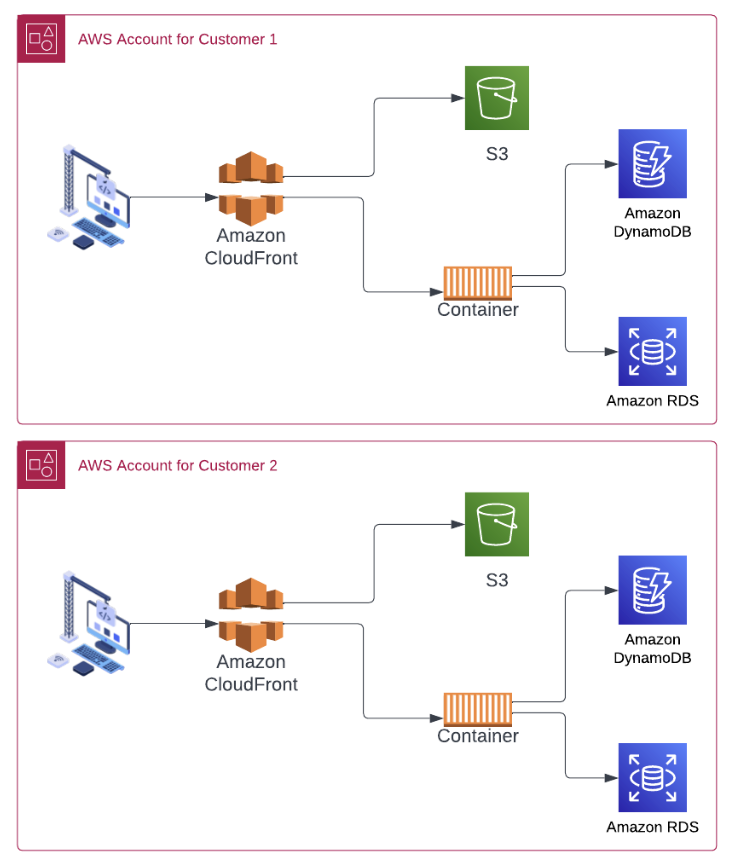

# Project Setup
To setup the project, you'll need an AWS account with Control Tower setup in it with all the basic settings. Once you have that set the required environment variables.

In [ ]:
export ACCOUNT_EMAIL_USER=YOUR_EMAIL_ADDRESS # This is the part of your email address before the @
export ACCOUNT_EMAIL_DOMAIN=YOUR_EMAIL_DOMAIN # this is the portion of the email address after the @

## Deploying the central stack
Run cdk deploy in order to deploy the primary stack. This stack will deploy an API with an API key, along with the nessisary components used to create, track, and deploy to accounts.

In [ ]:
cdk deploy

### Outputs
The outputs from this stack will be used in later steps

**AccountsDB**: The dynamodb name to use if manually deploying pipelines

**ManagementApiUrl**: The url of the endpoint used to demonstrate integrations

**ManagementApiKey**: The api key to use with the url

**CodeRepo**: The code repository to put central and product resources in.

**S3DataLake**: A bucket which data will be placed into as new accounts are created and existing accounts are updated

## Finish central account setup
To finish the account setup, pull the code commit repo which is output, and place the source code from this repository in it and commit it. After that, create two branches named "1.0" and "2.0".

## Creating an account
Replace the placeholders below with the outputs from the cdk deployment

In [ ]:
export ManagementApiUrl="URL_PLACEHOLDER" # The url for the endpoint created by the cdk
export ManagementApiKey="API_KEY_PLACEHOLDER" # The api key created by the cdk

For the endpoint, the following structure will be used to create new accounts and update existing accounts:

{

    "accountId": "",

    "customerName": "",
    
    "expiration": "YYYY-mm-dd",
    
    "products": [{ "name": "webapp", "version": "1.0"}],
    
    "adminEmails": ["$ACCOUNT_EMAIL_USER@YOUR_EMAIL_DOMAIN"]

}

by not including the accountId, the API will create a new account and return the new account id

In [ ]:
# The following sends a put request to the management api to create a new account
curl -X PUT -H "Content-Type: application/json" -d '{ "customerName": "unicorncorp", "expiration": "2023-01-01", "products": [{ "name": "webapp", "version": "1.0"}], "adminEmails":["$ACCOUNT_EMAIL_USER@YOUR_EMAIL_DOMAIN"] }' $ManagementApiUrl


# Following the account creation process
The account creation process follows the process bellow.

**Api Gateway** -> **BuildAccountLambda**: Initiates the account creation or update.

**BuildAccountLambda** -> **AccountCreateStateMachine**: The workflow for creating or updating an account

**AccountCreateStateMachine** -> **BuildAccountLambda**: Creates or updates the AWS Account for the specified account, and kicks of the creation of a Control Tower integrated account

**Cloudwatch Rule** -> **HandleAccountCreatedEvent**: On the completion of the account creation, notifies AccountCreateStateMachine that the step is complete

**AccountCreateStateMachine** -> **PipelineCentralSaasCodeBuild**: Pulls the updated configurations for the DynamoDB and performs a deployemnt of the central stack with all new accounts to create their pipelines

**AccountCreateStateMachine** -> **ReleaseProductCodePipelineTask**: Calls the newly created release pipeline for the new account in order to deploy the SaaS product.

### Manual Step
In order to facilitate the deployment the first time through, this project has a manual approval step. This step notifies an SNS topic which then kicks off a step function which at a specific deployment window will execute the changeset created by the release pipeline.

## What is stored in DynamoDB
In the DynamoDB, configurations are stored for the last time the account was updated, the product version and various other features. These are also extracted real-time and placed into an S3 bucket which represents a basic datalake. Not included in this project is the glue crawler. The S3 bucket is designed to be able to have a glue cralwer crawl the data in order to enable Athena and Quicksight reporting on the state of the systems.

## Manually deploying updates
To manually deploy updates there are two steps.

### Step 1
Pull all the accounts into the "./temp/accounts.json" file

In [ ]:
export DYNAMODB_TABLE_NAME=YOUR_DYNAMODB_TABLE_NAME # The name of the dynamodb table created by the cdk

# Create the ./temp/accounts.json file
npm run pullenv

### Step 2
After the ./temp/accounts.json is created then deploy the cdk

In [ ]:
cdk deploy